<a href="https://colab.research.google.com/github/yatindma/Automated-Response-Suggestion-for-Email/blob/master/Smart_Gmail_Reply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Overview </h2>

Here we'll try to predict the Short email responses.<br>
As most of the emails have shorter replies.<br>
So that it can be easy to reply, without the hassle of typing.<br>
It can help in saving the time of the person.<br>

########################################################

Will update later.
########################################################


[my kilnkn](www.com)




In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h4> Reading the data </h4>

In [0]:

data = pd.read_csv('qa_dataset.csv', encoding = "ISO-8859-1", low_memory=False) 

In [143]:
data.head(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Alessandro_Volta,Was Volta an Italian physicist?,yes,easy,easy,data/set4/a10
1,Alessandro_Volta,Is Volta buried in the city of Pittsburgh?,no,easy,easy,data/set4/a10


In [0]:
# data['Answer'] = 'start_ ' + data['Answer'] + ' _end'

In [145]:
type(data)

pandas.core.frame.DataFrame

<h4>convert data into lower case</h4>

In [146]:


data = data.apply(lambda x: x.astype(str).str.lower())
data.head(4)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,alessandro_volta,was volta an italian physicist?,yes,easy,easy,data/set4/a10
1,alessandro_volta,is volta buried in the city of pittsburgh?,no,easy,easy,data/set4/a10
2,alessandro_volta,did volta have a passion for the study of elec...,yes,easy,medium,data/set4/a10
3,alessandro_volta,what is the battery made by volta credited to be?,the first cell,medium,medium,data/set4/a10


In [0]:
#Remove the full stops from the dataframe answers

bad_chars = [';', ':', '!', "*",'.',')','(','?']

preprocessed_answers = []
for answer in data['Answer'].values:
  for i in bad_chars : 
    answer = answer.replace(i, '')
  preprocessed_answers.append(answer)



In [0]:
data['Answer'] = preprocessed_answers

In [0]:
#trimming the string the dataframe  
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [0]:
answers_list = list(data['Answer'].values)
answers_dict = {i:answers_list.count(i) for i in answers_list}

In [0]:
from collections import OrderedDict
answers_dict_sorted = OrderedDict(sorted(answers_dict.items(), key=lambda x: x[1]))

In [0]:
answers = []
keys = []
for item in answers_dict_sorted.items():
  answers.append(item[0])
  keys.append(item[1])

In [0]:
answers.reverse()
keys.reverse()

In [0]:
#top 10 answers
top_5_answers = answers[:5]
top_5_keys = keys[:5]

In [0]:
temp_answer_list = []
i = 0
for key in top_5_keys:
  for _ in range(0,key):
    temp_answer_list.append(top_5_answers[i])
  i += 1

<b>
Article title can be used while giving the sentence for tokenizing later 
Question do we need to preprocess the data
Answer mai kitne repeated h
</b>


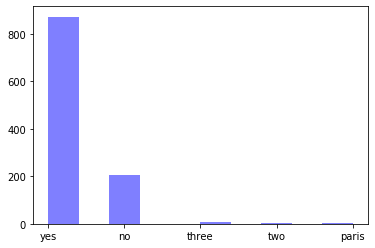

In [156]:
plt.hist(temp_answer_list, 10,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

From the above graph we can observe that 
<b>yes</b> and <b>no</b> replies are the most common answers in the mails 

number of email don' have any reply : 1
**************************************************
Max length : 920
**************************************************
Min Length : 1
**************************************************
Average Length : 24.696948920123415
**************************************************
No of unique replies : 169
**************************************************
--------------------------------------------------
Distribution of the words
--------------------------------------------------


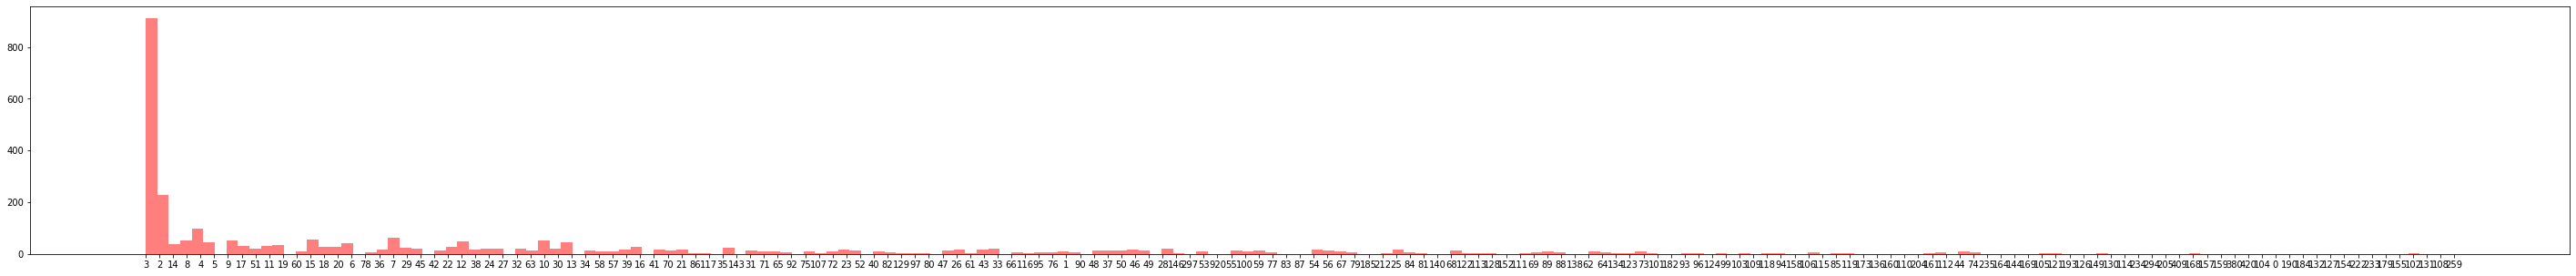

In [157]:
import matplotlib
matplotlib.rc('figure', figsize=[50,5])
#Getting the length of each Answer
data["Answer Length"]= data["Answer"].str.len()
len_answers = data["Answer Length"].values

#converting datatype to string
len_str_arr = []
for num in len_answers:
  len_str_arr.append(str(num)) 

no_reply_counter = 0
for num in len_answers:
  if num == 0:
    no_reply_counter += 1

temp_arr = []
for indx in len_answers:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)
    
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_answers)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(temp_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_answers)))/(len(list(len_answers))))
print('*' * 50)

print("No of unique replies", end = ' : ')
print(len(list(set(len_answers))))
print('*' * 50)


print('-' * 50)
print("Distribution of the words")
print('-' * 50)

plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='r',
         alpha=0.5)
plt.show()

In [0]:
data['Answer'] = 'start_ ' + data['Answer'] + ' _end'

From above graphs and data we observed that <b>maximun replies have less words. </b><br><br>
and <b>average length</b> if reply is nearly <b>25</b> words<br><br>
We have <b>169</b> unique replies


<h2> Check for emails </h2>

In [0]:
all_questions = data['Question'].values

In [0]:
#Preprocessing Questions 
#Remove the full stops from the dataframe answers

bad_chars = [';', ':', '!', "*",'.',')','(','?']

preprocessed_question = []
for question in all_questions:
  for i in bad_chars : 
    question = question.replace(i, '')
  preprocessed_question.append(question)



<h3> Words stemming </h3>

In [0]:
#Performing stammering here
# We are having less data
from nltk.stem import PorterStemmer
stemmed_sent = []
for sent in preprocessed_question:
  word_arr = []
  for word in sent.split():
    word_arr.append(porter.stem(word))
  temp_str = ""
  for words in word_arr:
    temp_str += words + " "
  stemmed_sent.append(temp_str)

In [0]:
data['Question'] = stemmed_sent

In [0]:
#trimming the string the dataframe  
#because after removal of the special character trimming might have lost
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


number of email don' have any reply : 0
**************************************************
Max length : 236
**************************************************
Min Length : 4
**************************************************
Average Length : 46.40281110730202
**************************************************
No of unique replies : 144
**************************************************
--------------------------------------------------
Distribution of the words
--------------------------------------------------


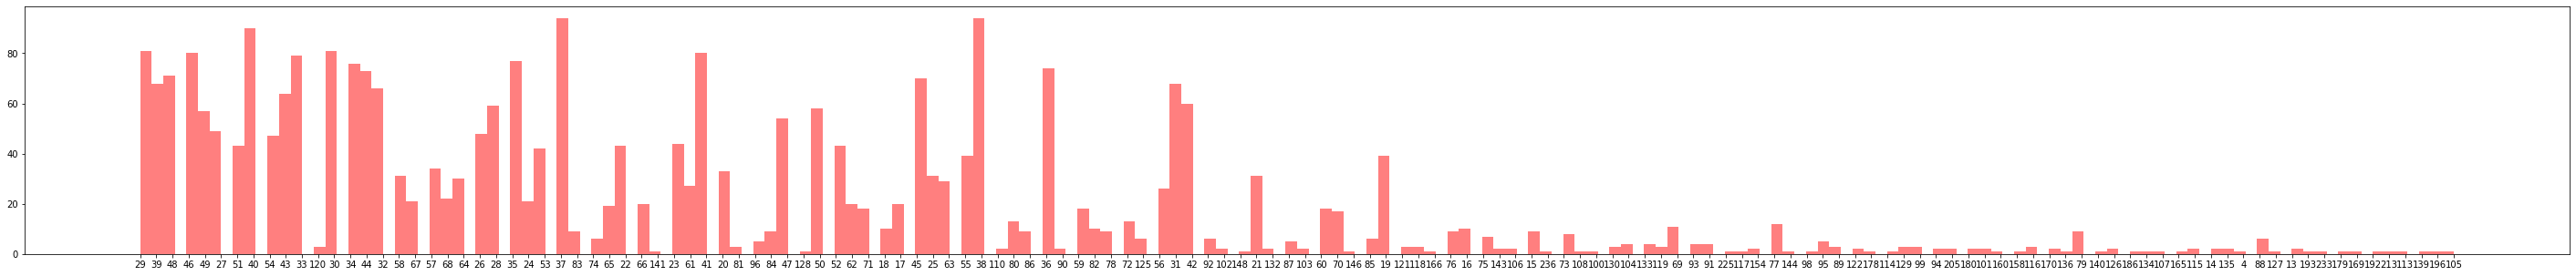

In [164]:
import matplotlib
matplotlib.rc('figure', figsize=[50,5])
#Getting the length of each Answer
data["Question_length"]= data["Question"].str.len()
len_questions = data["Question_length"].values

#converting datatype to string
len_str_arr = []
for num in len_questions:
  len_str_arr.append(str(num)) 

no_reply_counter = 0
for num in len_questions:
  if num == 0:
    no_reply_counter += 1

temp_arr = []
for indx in len_questions:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)
    
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_questions)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(temp_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_questions)))/(len(list(len_questions))))
print('*' * 50)

print("No of unique replies", end = ' : ')
print(len(list(set(len_questions))))
print('*' * 50)


print('-' * 50)
print("Distribution of the words")
print('-' * 50)

plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='r',
         alpha=0.5)
plt.show()

From the above graph we can observe that we have minimum of <b>4</b> character in the email<br><br>
maximum length of the Questions is <b>270</b><br><br>
and we have unique distribution of <b>156</b> questions.

Top Unique distribution of Questions in dataset

In [165]:
data.head(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile,Answer Length,Question_length
0,alessandro_volta,wa volta an italian physicist,start_ yes _end,easy,easy,data/set4/a10,3,29
1,alessandro_volta,is volta buri in the citi of pittsburgh,start_ no _end,easy,easy,data/set4/a10,2,39


In [0]:
question_list = list(data['Question'].values)
questions_dict = {i:question_list.count(i) for i in question_list}

In [0]:
from collections import OrderedDict
questions_dict_sorted = OrderedDict(sorted(questions_dict.items(), key=lambda x: x[1]))

In [0]:
questions = []
keys = []
for item in questions_dict_sorted.items():
  questions.append(item[0])
  keys.append(item[1])

In [0]:
questions.reverse()
keys.reverse()

In [0]:
#top 10 answers
top_5_questions = questions[:5]
top_5_keys = keys[:5]

In [0]:
temp_questions_list = []
i = 0
for key in top_5_keys:
  for _ in range(0,key):
    temp_questions_list.append(top_5_questions[i])
  i += 1

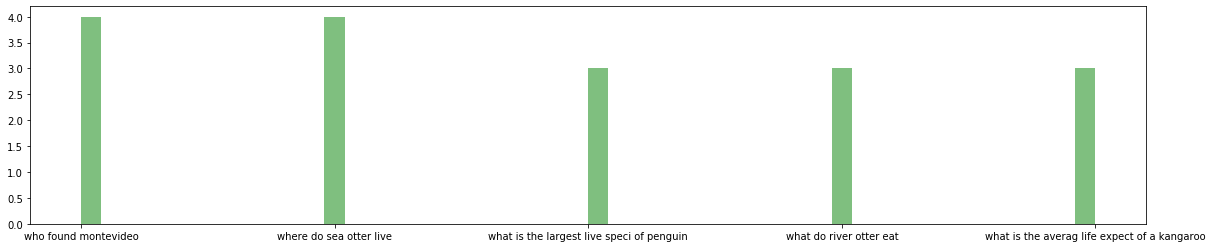

In [172]:
import matplotlib
matplotlib.rc('figure', figsize=[20,4])
plt.hist(temp_questions_list, 50,
         histtype='bar',
         facecolor='g',
         alpha=0.5)
plt.show()

Here we can see the top 5 repeated questions,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; It's not looking usefull for any interpretation

In [173]:
data.head(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile,Answer Length,Question_length
0,alessandro_volta,wa volta an italian physicist,start_ yes _end,easy,easy,data/set4/a10,3,29
1,alessandro_volta,is volta buri in the citi of pittsburgh,start_ no _end,easy,easy,data/set4/a10,2,39


In [174]:
data.tail(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile,Answer Length,Question_length
2915,woodrow_wilson,"wa wilson , a staunch oppon of antisemit , sym...",start_ yes _end,nan,easy,data/set3/a8,3,105
2916,woodrow_wilson,what happen in 1917,"start_ raised billions through liberty loans, ...",nan,medium,data/set3/a8,259,19


Here we can <b>combine the Article Title with the question</b> which can help in getting better suggestions.

<b>Modelling Approaches:<br><i>
# here before modeling we can stammer the sentences : Playing ko play
* Seq2seq model
* Bi-Directional LSTM
* Attention Layer
* Beam Search</b></i>

# Modeling

In [0]:
# Vocabulary of Question
all_email_words=[]
for quest in data.Question:
    for word in quest.split():
        if word not in all_email_words:
            all_email_words.append(word)

# Vocabulary of Replies 
all_reply_words=[]
for mar in data.Answer:
    for word in mar.split():
        if word not in all_reply_words:
            all_reply_words.append(word)

In [0]:
all_email_words = list(set(all_email_words))

In [0]:
all_reply_words = list(set(all_reply_words))

In [178]:
import numpy as np
lenght_list=[]
for l in data.Question.values:
    lenght_list.append(len(l.split(' ')))
max_length_src = max(lenght_list)
max_length_src

44

In [179]:
lenght_list=[]
for l in data.Answer:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

158

In [180]:

#All input words
input_words = sorted(list(all_email_words))
target_words = sorted(list(all_reply_words))

# get the length of the vocabalary // Kitne words // this will help while performing embedding layer
num_encoder_tokens = len(all_email_words) + 1
num_decoder_tokens = len(all_reply_words) + 1

num_encoder_tokens, num_decoder_tokens

(3672, 3776)

In [0]:
# from word to token we can get
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
# from token to word we can get
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [183]:
from sklearn.utils import shuffle
data = shuffle(data)
data.head(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile,Answer Length,Question_length
2721,theodore_roosevelt,what did roosevelt do to improv hi physic condit,start_ roosevelt took up exercise _end,medium,hard,data/set3/a7,26,48
2015,finland,is the capit citi oslo,start_ no _end,easy,easy,data/set2/a4,2,22


In [184]:
# Train - Test Split
from sklearn.model_selection import train_test_split
X, y = data.Question, data.Answer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((2625,), (292,))

In [0]:
def generate_batch(X=X_train, y=y_train, batch_size=1000):
    while True:
      # in every batch we are sending (batch_size) of sentences
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),
                    dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),
                    dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar,
                    num_decoder_tokens), dtype='float32')

            # for all the sentences in the batch
            for (i, (input_text, target_text)) in enumerate(zip(X[j:j
                    + batch_size], y[j:j + batch_size])):

                # for words in each sentence //Question
                for (t, word) in enumerate(input_text.split()):  # Question wale text ko tokenize kiya gaya
                    encoder_input_data[i] = input_token_index[word]  # encoder input seq

                # for each word in   Sentence
                for (t, word) in enumerate(target_text.split()):  # t is the length of the sentence
                    if t < len(target_text.split()):
                        decoder_input_data[i] = target_token_index[word]  # decoder input seq
                    if t > 0:
                        #one-hot encoding 
                        #and making it to the output shape from decoder
                        decoder_target_data[i, t - 1,
                                target_token_index[word]] = 1.
                                                       
            yield ([encoder_input_data, decoder_input_data],
                   decoder_target_data)  # this will help multiple return// like closure in swift


In [0]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,CuDNNLSTM,Concatenate
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

# Encoder
latent_dim = 64 # how much dimension of output we want form the embedding layer
encoder_inputs = Input(shape=(None,)) # mentioning the input shape row and collumns are still null

# **num_encoder_tokens** vocabulary size we are having

enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs) #Embedding layer # this layer will make it 3D

#training the LSTM on encoder
# encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_output, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(128, return_sequences=True, return_state=True))(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])


encoder_states = [state_h, state_c] #output and the cell state

In [0]:

#  Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,)) #Reply's input
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True) 
dec_emb = dec_emb_layer(decoder_inputs) # Reply sikhaye hum Embedding layer ko


# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.


decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_output, decoder_h, decoder_c = decoder_lstm(dec_emb,initial_state=encoder_states)


decoder_states = [decoder_h, decoder_c]

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_output)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
model.save_weights('nmt_weights.h5')

In [0]:
model.load_weights('nmt_weights.h5')

In [0]:
model.save('my_model.h5')

<h3> Adding Attention layer </h3>

In [192]:
from keras.models import load_model
custom_objects = {
    'AttentionLayer':AttentionLayer
}
model = load_model('my_model.h5',custom_objects = custom_objects)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [193]:
encoder_output.shape

TensorShape([Dimension(None), Dimension(None), Dimension(256)])

In [194]:
decoder_output.shape

TensorShape([Dimension(None), Dimension(None), Dimension(256)])

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [196]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 64)     235008      input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, None, 256),  197632      embedding_6[0][0]                
____________________________________________________________________________________________

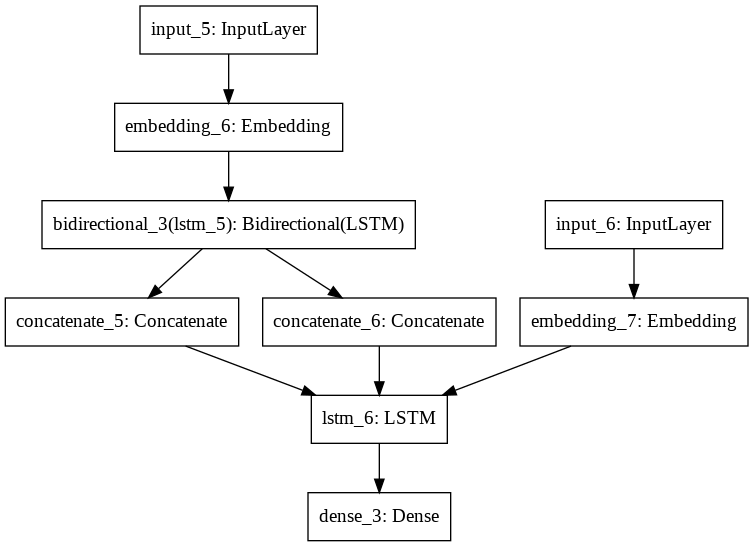

In [197]:
from keras.utils import plot_model
plot_model(model, to_file='multilayer_perceptron_graph.png')

In [198]:
import numpy as np
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = 1),
                    steps_per_epoch = 10,
                    epochs=2,
                    validation_data = generate_batch(X_test, y_test, batch_size = 1),
                    validation_steps = 10
                    )


Epoch 1/2
10/10 [==============================] - 12s 1s/step - loss: 0.3542 - acc: 0.0032 - val_loss: 0.3745 - val_acc: 0.0063
Epoch 2/2
10/10 [==============================] - 7s 720ms/step - loss: 0.1761 - acc: 0.0063 - val_loss: 0.1643 - val_acc: 0.0063


In [199]:
encoder_output

<tf.Tensor 'bidirectional_3/concat:0' shape=(?, ?, 256) dtype=float32>

In [0]:
#Making new model so that we can predict the output
# taking all input and output of the encoder from the previous model to here
    #encoder_inputs: It's the tokenized and padded words from the Question
encoder_model = Model(encoder_inputs, encoder_states) # this is not used for the input in the LSTM

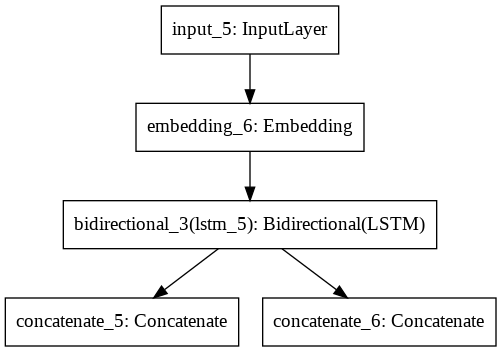

In [201]:
from keras.utils import plot_model
plot_model(encoder_model, to_file='multilayer_perceptron_graph.png')

In [202]:
encoder_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 64)     235008      input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, None, 256),  197632      embedding_6[0][0]                
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 256)          0           bidirectional_3[0][1]            
                                                                 bidirectional_3[0][3]      

___

In [0]:
#giving input to decoder
decoder_state_input_h = Input(shape=(256,)) # this will be the input form the encoders # cz 256 is from the encoder after concatination 
decoder_state_input_c = Input(shape=(256,)) #cell state after the encoder

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#Reply words tokenized
dec_emb2= dec_emb_layer(decoder_inputs) #Get the embeddings of the decoder sequence

#decoder ka output and cell state nikal liya 
    # decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
        # here dec_emb2 we passed the output from the embedding later which for trained on tokenized sentensed of Reply words
decoder_outputs, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

#added both states from the decoder 
decoder_states = [state_h2, state_c2]  

# Passing the output from the decoder model to the dense layer
decoder_output_dense = decoder_dense(decoder_outputs)

# Final decoder model
# decoder_inputs : Embedding layer ko Reply sentence tokenizer
# decoder_states_inputs : this is from the encoder
# decoder_outputs2 : #ye decoder ka output he //predicted values from the decoder not the cellstate or output(h)
# decoder_states2 : #ye output(h) & cell state h from decoder


decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_output_dense] + decoder_states)

In [204]:
print(decoder_model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 64)     241664      input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 256)          0                                            
____________________________________________________________________________________________

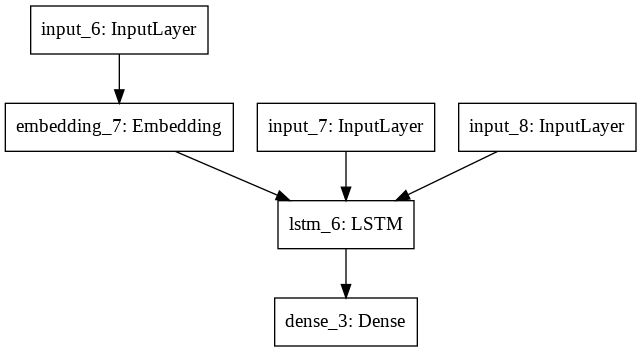

In [205]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='multilayer_perceptron_graph.png')

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['start_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_end' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [0]:

(input_seq, actual_output), _ = next(train_gen)

In [209]:
y_train.head()

1184    start_ although previously attributed to ghirl...
138                                   start_ cellist _end
1558    start_ taipei produces textiles, apparel, elec...
1241                                      start_ yes _end
390                                        start_ no _end
Name: Answer, dtype: object

In [0]:
# y_train_ = 'Start_ ' + X_train + ' _End'
# y_test_ = 'Start_ ' + X_test + ' _End'

In [211]:
X_train.head()

1184    is the larger work now almost univers attribut...
138              what is a person who play the cello call
1558                               what doe taipei produc
1241       is melbourn home to australia' busiest seaport
390                         is lyre play in mordern greec
Name: Question, dtype: object

In [213]:
decode_sequence(input_seq)

' railroads, ernest connecticut connecticut pegs met'

In [214]:
decoded_sentence = decode_sequence(input_seq)
print('Input Question sentence:', X_train[k:k+1].values[0])
print('Actual Reply :', y_train[k:k+1].values[0][6:-4])
print('Predicted Reply :', decoded_sentence[:-4])

Input Question sentence: is the larger work now almost univers attribut to leonardo
Actual Reply :  although previously attributed to ghirlandaio, the larger work is now almost universally attributed to leonardo 
Predicted Reply :  railroads, ernest connecticut connecticut pegs


In [215]:
k+=1
decoded_sentence = decode_sequence(input_seq)
print('Input Question sentence:', X_train[k:k+1].values[0])
print('Actual Reply:', y_train[k:k+1].values[0][6:-4])
print('Predicted Reply:', decoded_sentence[:-4])

Input Question sentence: what is a person who play the cello call
Actual Reply:  cellist 
Predicted Reply:  railroads, ernest connecticut connecticut pegs


# Attention Layer

In [0]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        print("here at call ")
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            print("here at energy_step ")
            """ Step function for computing energy for a single decoder state """
            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            
            de_hidden = inputs.shape[-1]
            print("here is error1")
            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            print("here is error2")
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden)) # error is happening
            
            print("no error till here")
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            print("here at context_step ")
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            print("here at create_inital_state ")
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            print("reaching here")
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])    # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        print("here at compute_output_shape ")
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]